In [1]:
# torch
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

# torchvision
import torchvision
import torchvision.models as models
from torchvision import transforms

import numpy as np
from sklearn.model_selection import train_test_split

import PIL
import matplotlib.pyplot as plt
import seaborn as sns # 0.11.2

import os
from glob import glob

In [2]:
%matplotlib inline

In [3]:
data_path = "./data/Fish_Dataset/Fish_Dataset/"

In [4]:
img_dir_path = glob(f'{data_path}/**/*.png', recursive=True)

In [5]:
images_paths = [ img_path for img_path in img_dir_path if 'GT' not in str(img_path) ]

In [6]:
print(f"Number of training images : {len(images_paths)}")

Number of training images : 9000


In [7]:
labels = [ os.path.split(os.path.split(name)[0])[1] for name in images_paths ]
print(f'Number of labels : {len(labels)}')

Number of labels : 9000


In [8]:
classes = list(set(labels))
label_encoder = { label : i for i, label in enumerate(classes) }
print(f'Label Encoder : {label_encoder}')

Label Encoder : {'Sea Bass': 0, 'Hourse Mackerel': 1, 'Red Sea Bream': 2, 'Black Sea Sprat': 3, 'Shrimp': 4, 'Striped Red Mullet': 5, 'Trout': 6, 'Red Mullet': 7, 'Gilt-Head Bream': 8}


In [9]:
labels_encoded = [ label_encoder[label] for label in labels ]

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

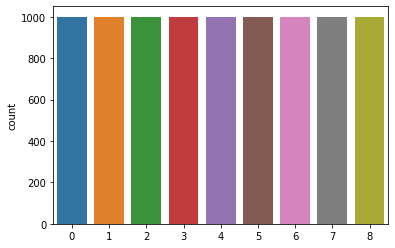

In [10]:
sns.countplot(labels_encoded)

In [11]:
rand_img_paths = []
for i in classes:
    path = os.path.join(os.path.join(data_path, i), i)
    rand_path = list(glob(path + '/*')[:5])
    rand_img_paths.append(rand_path)

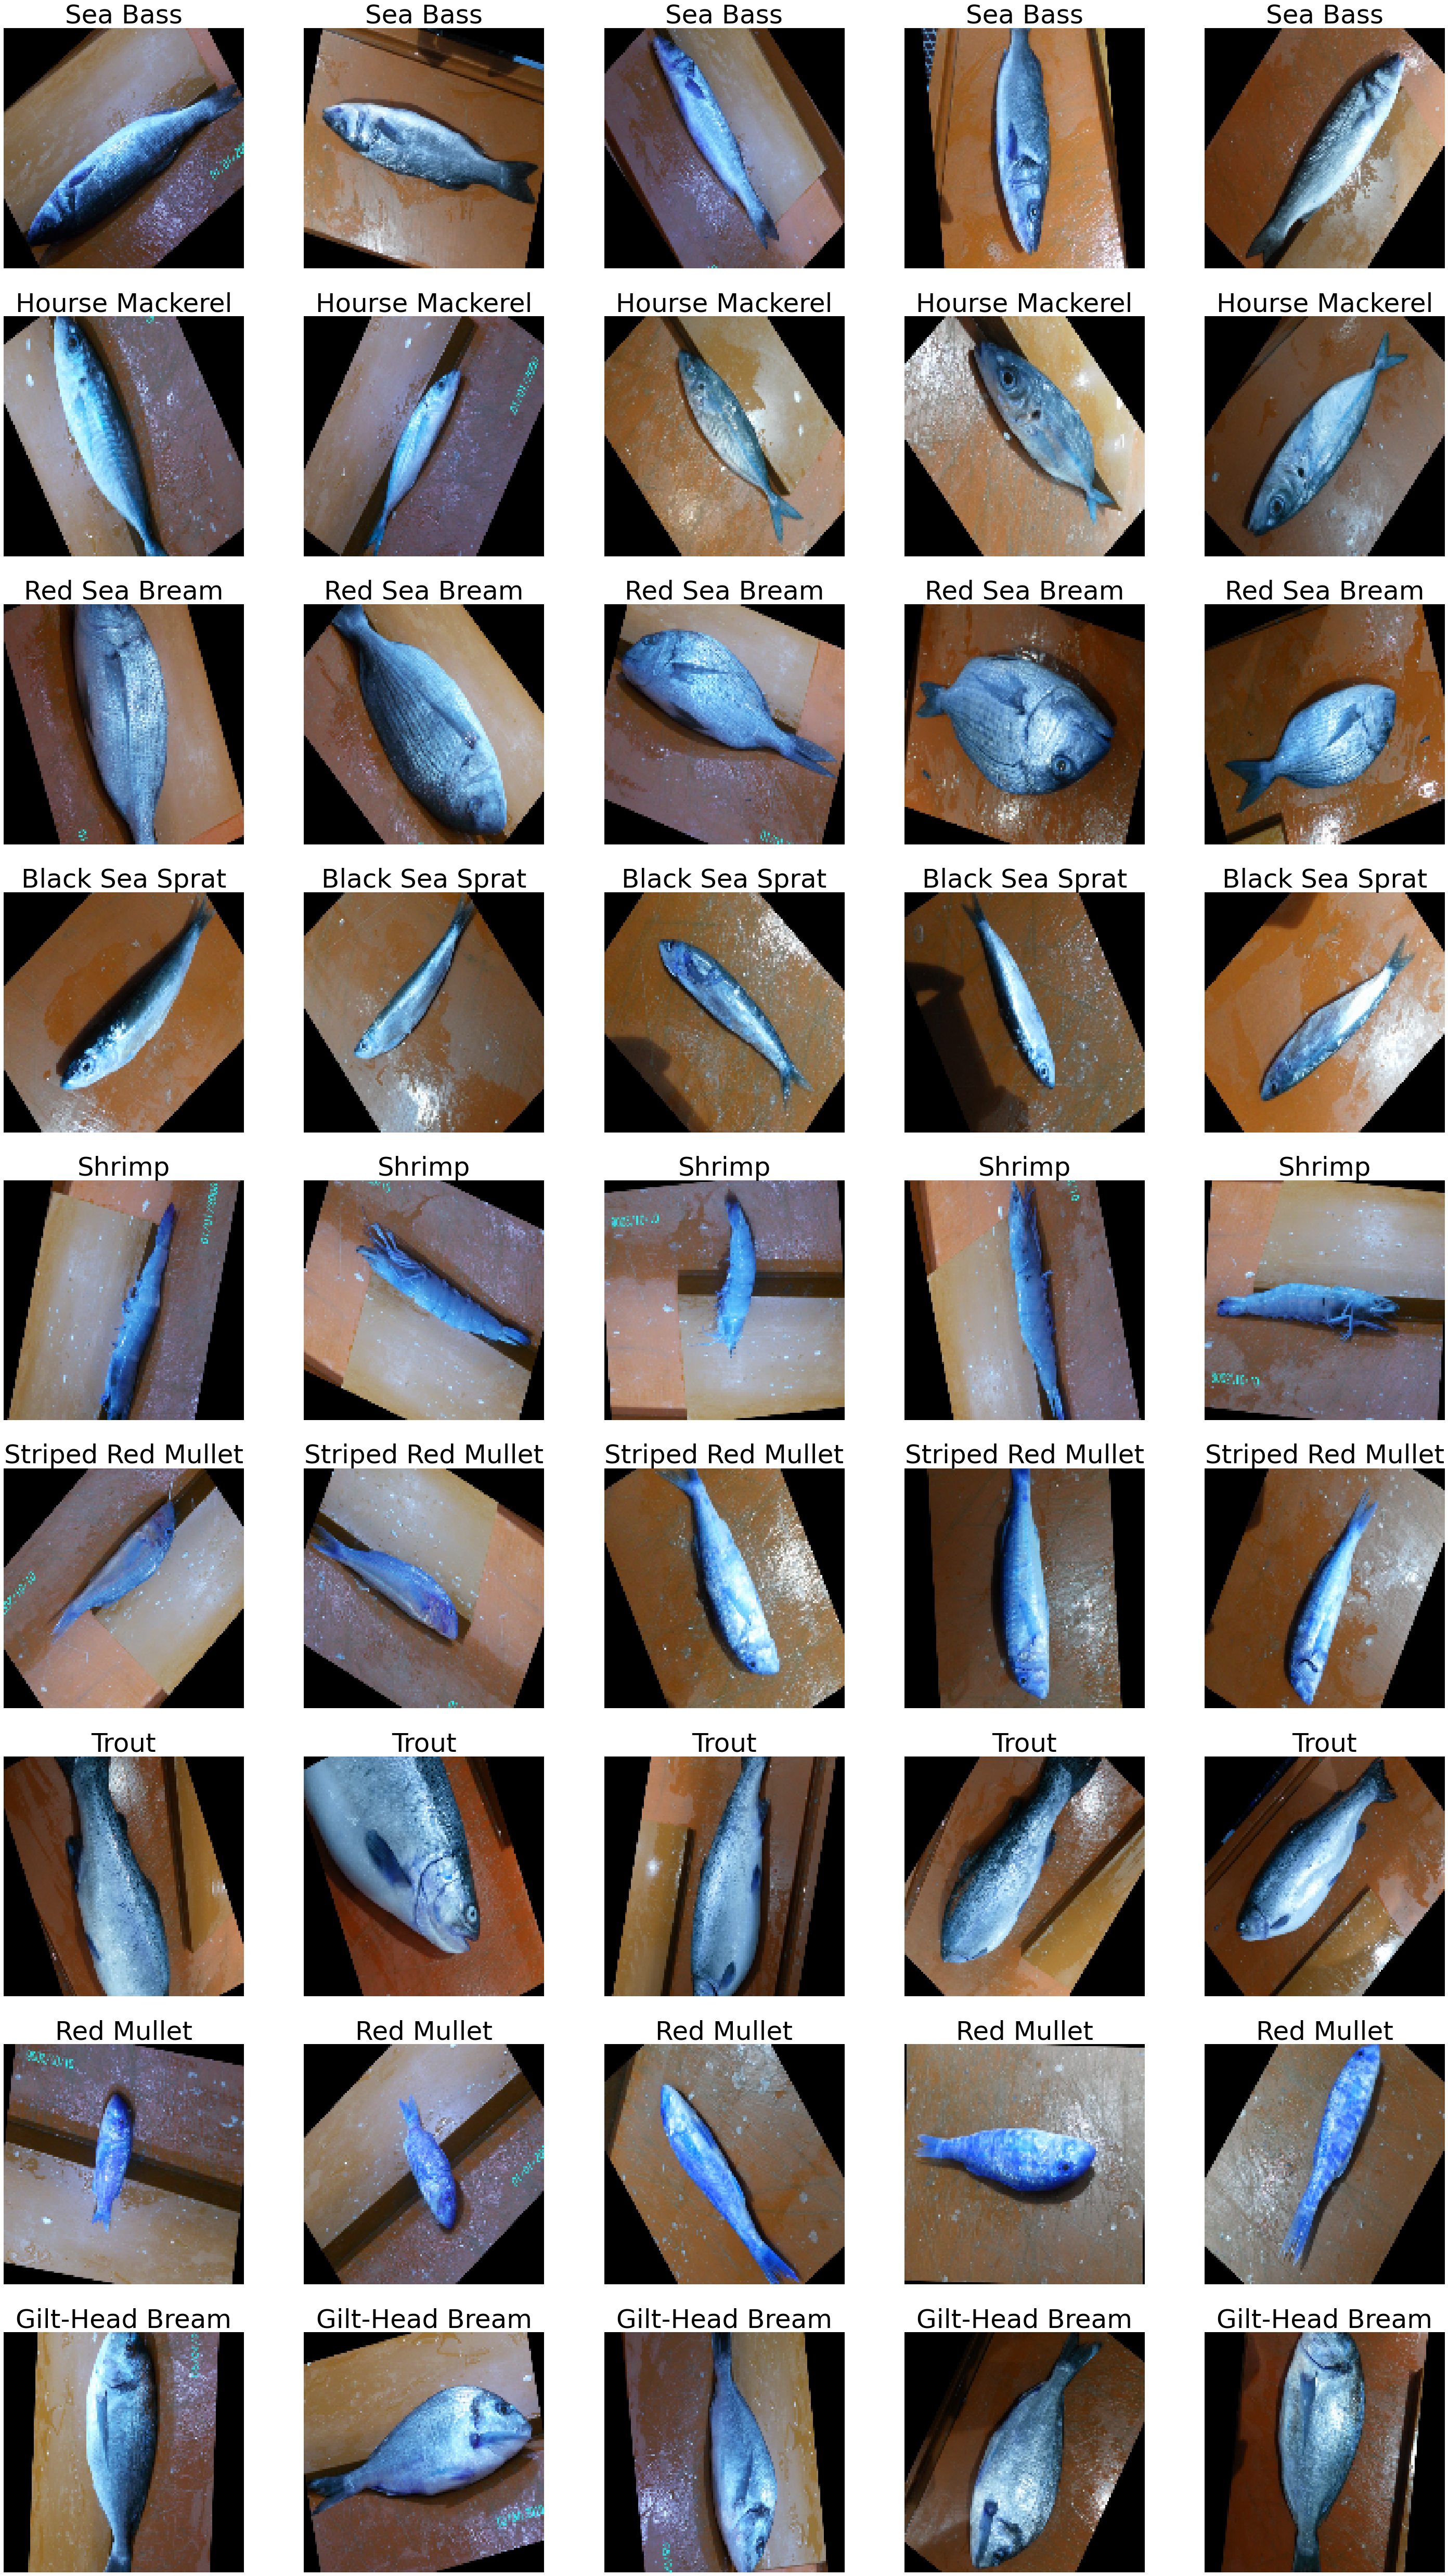

In [12]:
import cv2
fig = plt.figure(figsize=(50, 90))
columns, rows = 5, 9
num = 1

for i in range(len(classes)):
    for j in range(len(rand_img_paths[i])):
        img = cv2.imread(rand_img_paths[i][j])
        img = cv2.resize(img, (128, 128))
        fig.add_subplot(rows, columns, num)
        num += 1
        plt.title(classes[i], fontsize=50)
        plt.imshow(img)
        plt.axis(False)

In [13]:
class fishDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images    = images
        self.labels    = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        input_image = self.images[idx]
        label       = self.labels[idx]
        image       = PIL.Image.open(input_image)
        image       = self.transform(image)
        return image, label

In [14]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [15]:
data, test_data, labels, test_labels = train_test_split(images_paths, labels_encoded, test_size=0.1, shuffle=True)
train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.1, shuffle=True)

In [16]:
batch_size = 256

train_ds = fishDataset(
    images    = train_data,
    labels    = train_labels,
    transform = data_transforms['train']
)

train_loader = DataLoader(
    train_ds,
    batch_size = batch_size,
    shuffle    = True
)

val_ds = fishDataset(
    images    = val_data,
    labels    = val_labels,
    transform = data_transforms['val']
)

val_loader = DataLoader(
    val_ds,
    batch_size = batch_size,
    shuffle    = True
)

test_ds = fishDataset(
    images    = test_data,
    labels    = test_labels,
    transform = data_transforms['val']
)

test_loader = DataLoader(
    test_ds,
    batch_size = batch_size,
    shuffle    = False
)

In [17]:
labels_dic = { i : label for i, label in enumerate(classes) }
def show_batch(loader, batch_size, labels_dic):
    rows_number = 1
    cols_number = 2
    if batch_size > 2:
        cols_number = 8
        rows_number = batch_size // cols_number
        
    fig = plt.figure(figsize=(48, 30))
    images,labels = next(iter(loader))

    for i,data in enumerate(images,1):
        ax = fig.add_subplot(rows_number, cols_number, i)
        plt.imshow(data.permute(1,2,0).numpy())
        ax.set_title(labels_dic[labels[i-1].item()],fontsize = 20)
        plt.axis(False)
    plt.show()

In [19]:
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features,9)
for param in model.fc.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [22]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [23]:
print("Current cuda device", torch.cuda.current_device())
print("Count of using GPUs", torch.cuda.device_count())

Current cuda device 0
Count of using GPUs 1


In [24]:
optimizer = torch.optim.Adam(model.fc.parameters(),lr= 0.001)
criterion = torch.nn.CrossEntropyLoss()

In [25]:
model = model.to(device)
model.cuda()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [28]:
from tqdm import tqdm
n_epochs = 20
valid_loss_min = np.Inf
for epoch in range(1,n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    train_running_correct= 0.0
    val_running_correct = 0.0
    
    model.train()
    
    print(f"Train Epochs : {epoch}")
    for data,target in tqdm(train_loader):
        data,target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output,target)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        _,preds = torch.max(output.data,1)
        train_running_correct += (preds==target).sum().item()
    
    model.eval()
    print(f"Validation Epochs : {epoch}")
    for data,target in tqdm(val_loader):
        data,target = data.to(device),target.to(device)
        output = model(data)
        loss = criterion(output,target)
        valid_loss+=loss.item()*data.size(0)
        _,preds =torch.max(output.data,1)
        val_running_correct += (preds==target).sum().item()
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_accuracy = 100. * train_running_correct/len(train_loader.sampler)
    valid_accuracy = 100. * val_running_correct/len(val_loader.sampler)
    print('Epoch: {} , Training Loss: {:.6f},Training Accuracy: {:.3f} ,Validation Loss: {:.6f}, Validation Accuracy: {:.3f}'.format(epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
    
    if valid_loss<=valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_fish.pt')
        valid_loss_min = valid_loss

  0%|          | 0/29 [00:00<?, ?it/s]

Train Epochs : 1


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 1


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 , Training Loss: 0.331169,Training Accuracy: 97.627 ,Validation Loss: 0.272114, Validation Accuracy: 97.654
Validation loss decreased (inf --> 0.272114).  Saving model ...
Train Epochs : 2


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 2


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2 , Training Loss: 0.226874,Training Accuracy: 98.381 ,Validation Loss: 0.200294, Validation Accuracy: 97.901
Validation loss decreased (0.272114 --> 0.200294).  Saving model ...
Train Epochs : 3


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 3


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3 , Training Loss: 0.174415,Training Accuracy: 98.532 ,Validation Loss: 0.157787, Validation Accuracy: 98.519
Validation loss decreased (0.200294 --> 0.157787).  Saving model ...
Train Epochs : 4


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 4


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4 , Training Loss: 0.143406,Training Accuracy: 98.848 ,Validation Loss: 0.134520, Validation Accuracy: 99.012
Validation loss decreased (0.157787 --> 0.134520).  Saving model ...
Train Epochs : 5


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 5


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5 , Training Loss: 0.117473,Training Accuracy: 99.177 ,Validation Loss: 0.116511, Validation Accuracy: 98.889
Validation loss decreased (0.134520 --> 0.116511).  Saving model ...
Train Epochs : 6


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 6


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6 , Training Loss: 0.102299,Training Accuracy: 99.273 ,Validation Loss: 0.104562, Validation Accuracy: 99.012
Validation loss decreased (0.116511 --> 0.104562).  Saving model ...
Train Epochs : 7


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 7


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7 , Training Loss: 0.088210,Training Accuracy: 99.492 ,Validation Loss: 0.086292, Validation Accuracy: 99.259
Validation loss decreased (0.104562 --> 0.086292).  Saving model ...
Train Epochs : 8


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 8


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8 , Training Loss: 0.080979,Training Accuracy: 99.328 ,Validation Loss: 0.080934, Validation Accuracy: 99.259
Validation loss decreased (0.086292 --> 0.080934).  Saving model ...
Train Epochs : 9


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 9


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9 , Training Loss: 0.071010,Training Accuracy: 99.438 ,Validation Loss: 0.075034, Validation Accuracy: 99.136
Validation loss decreased (0.080934 --> 0.075034).  Saving model ...
Train Epochs : 10


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 10


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 10 , Training Loss: 0.065672,Training Accuracy: 99.451 ,Validation Loss: 0.068691, Validation Accuracy: 99.136
Validation loss decreased (0.075034 --> 0.068691).  Saving model ...
Train Epochs : 11


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 11


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 11 , Training Loss: 0.059375,Training Accuracy: 99.520 ,Validation Loss: 0.060989, Validation Accuracy: 99.506
Validation loss decreased (0.068691 --> 0.060989).  Saving model ...
Train Epochs : 12


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 12


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 12 , Training Loss: 0.054233,Training Accuracy: 99.602 ,Validation Loss: 0.060803, Validation Accuracy: 99.136
Validation loss decreased (0.060989 --> 0.060803).  Saving model ...
Train Epochs : 13


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 13


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 13 , Training Loss: 0.049812,Training Accuracy: 99.643 ,Validation Loss: 0.059795, Validation Accuracy: 99.383
Validation loss decreased (0.060803 --> 0.059795).  Saving model ...
Train Epochs : 14


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 14


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 14 , Training Loss: 0.045787,Training Accuracy: 99.753 ,Validation Loss: 0.049269, Validation Accuracy: 99.753
Validation loss decreased (0.059795 --> 0.049269).  Saving model ...
Train Epochs : 15


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 15


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 15 , Training Loss: 0.044020,Training Accuracy: 99.630 ,Validation Loss: 0.049145, Validation Accuracy: 99.630
Validation loss decreased (0.049269 --> 0.049145).  Saving model ...
Train Epochs : 16


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 16


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 16 , Training Loss: 0.040886,Training Accuracy: 99.712 ,Validation Loss: 0.045819, Validation Accuracy: 99.753
Validation loss decreased (0.049145 --> 0.045819).  Saving model ...
Train Epochs : 17


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 17


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 17 , Training Loss: 0.039061,Training Accuracy: 99.657 ,Validation Loss: 0.043113, Validation Accuracy: 99.383
Validation loss decreased (0.045819 --> 0.043113).  Saving model ...
Train Epochs : 18


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 18


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 18 , Training Loss: 0.036384,Training Accuracy: 99.781 ,Validation Loss: 0.041055, Validation Accuracy: 99.753
Validation loss decreased (0.043113 --> 0.041055).  Saving model ...
Train Epochs : 19


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 19


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 19 , Training Loss: 0.033785,Training Accuracy: 99.781 ,Validation Loss: 0.040069, Validation Accuracy: 99.630
Validation loss decreased (0.041055 --> 0.040069).  Saving model ...
Train Epochs : 20


  0%|          | 0/4 [00:00<?, ?it/s]

Validation Epochs : 20


100%|██████████| 4/4 [00:10<00:00,  2.74s/it]

Epoch: 20 , Training Loss: 0.033085,Training Accuracy: 99.767 ,Validation Loss: 0.040708, Validation Accuracy: 99.630


In [29]:
def eval_accuracy(loader):  
    model.eval()
    corrects = 0
    total = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        predictions = model(images)
        predict = torch.max(predictions.data, 1)[1].to(device)
        total += len(labels)
        corrects += (predict == labels).sum()
    accuracy = 100 * corrects / float(total)
    return accuracy

In [30]:
print(f' Accuracy on validation images: {eval_accuracy(val_loader)}')
print(f' Accuracy on train images: {eval_accuracy(train_loader)}')
print(f' Accuracy on test images: {eval_accuracy(test_loader)}')

 Accuracy on validation images: 99.62963104248047
 Accuracy on train images: 99.83538818359375
 Accuracy on test images: 99.55555725097656
